In [1]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation

from sklearn.preprocessing import MinMaxScaler

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

In [9]:
metric = 'Open' # What matric to model and predict
timestamp = 64 # Maximum number of timestamps to learn from
layers = 3 # Number of layers in LSTM
neurons = 264 # Number of neurons in each layer
epochs = 30 # Number of times the entire data needs to be looped upon
batch_size = 16 # Weights updated after n rows
validation_split = 0.1 # Percentage of data to validate the model when training
dropout = 0.2 # Regularisation parameter
optimizer = 'adam' 
loss = 'mean_squared_error'

In [4]:
loc = train.columns.get_loc(metric)
train_data = train.iloc[:,loc:loc + 1].values

sc = MinMaxScaler(feature_range = (0,1))

train_data = sc.fit_transform(train_data)

In [5]:
train_x = []
train_y = []
for i in range(len(train_data) - timestamp - 1):
    train_x.append(train_data[i : i + timestamp, 0])
    train_y.append(train_data[i + timestamp, 0])
train_x, train_y = np.array(train_x), np.array(train_y)

train_x = np.reshape(train_x, (train_x.shape[0],train_x.shape[1],1))

In [6]:
regressor = Sequential()
regressor.add(LSTM(neurons, return_sequences = True, input_shape = (train_x.shape[1],1)))
regressor.add(Dropout(dropout))

if layers > 2:
    for _ in range(2,layers):
        regressor.add(LSTM(neurons, return_sequences = True))
        regressor.add(Dropout(dropout))

regressor.add(LSTM(neurons))
regressor.add(Dropout(dropout))

regressor.add(Dense(units = 1))

regressor.compile(optimizer = optimizer,loss = loss)

In [10]:
from tensorflow.keras.callbacks import EarlyStopping


regressor.fit(train_x,train_y,epochs = epochs, batch_size = batch_size, validation_split = validation_split,
callbacks=EarlyStopping(monitor='val_loss', patience=5))


Epoch 1/30
190/190 [==============================] - 8s 44ms/step - loss: 3.6082e-04 - val_loss: 0.0012
Epoch 2/30
190/190 [==============================] - 8s 44ms/step - loss: 2.9005e-04 - val_loss: 6.6395e-04
Epoch 3/30
190/190 [==============================] - 8s 44ms/step - loss: 3.8808e-04 - val_loss: 0.0015
Epoch 4/30
190/190 [==============================] - 8s 43ms/step - loss: 2.6408e-04 - val_loss: 5.8632e-04
Epoch 5/30
190/190 [==============================] - 8s 43ms/step - loss: 2.4455e-04 - val_loss: 4.3985e-04
Epoch 6/30
190/190 [==============================] - 8s 43ms/step - loss: 3.5434e-04 - val_loss: 0.0037
Epoch 7/30
190/190 [==============================] - 8s 43ms/step - loss: 2.8227e-04 - val_loss: 0.0038
Epoch 8/30
190/190 [==============================] - 8s 43ms/step - loss: 3.1412e-04 - val_loss: 5.0937e-04
Epoch 9/30
190/190 [==============================] - 8s 44ms/step - loss: 2.2967e-04 - val_loss: 7.5513e-04
Epoch 10/30
190/190 [==============

In [11]:
test_data = pd.concat((train[len(train) - timestamp:][metric], test[metric]), axis = 0)
test_data = test_data.values
test_data = test_data.reshape(-1,1)

test_data = sc.transform(test_data)

test_x = []
test_y = []
for i in range(len(test_data) - timestamp - 1):
    test_x.append(test_data[i : i + timestamp, 0])
    test_y.append(test_data[i + timestamp, 0])
test_x, test_y = np.array(test_x), np.array(test_y)

test_x = np.reshape(test_x, (test_x.shape[0],test_x.shape[1],1))

In [12]:
predicted_price = sc.inverse_transform(regressor.predict(test_x))
real_stock_price = test[metric]

1/1 [==============================] - 1s 1s/step


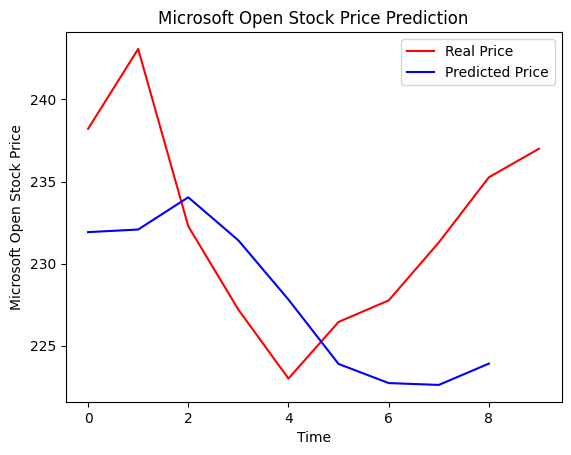

In [13]:
def plot_pred(metric, real_stock_price, predicted_price):
    plt.plot(real_stock_price,color = 'red', label = 'Real Price')
    plt.plot(predicted_price, color = 'blue', label = 'Predicted Price')
    plt.title(f'Microsoft {metric} Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel(f'Microsoft {metric} Stock Price')
    plt.legend()
    plt.show()

plot_pred(metric, real_stock_price, predicted_price)